# Evaluation of a single models to detect defects in steel sheet 

### 1. Requirments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset

from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import dataloader
from torch import nn
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, recall_score, precision_score

### 2. Parameters

In [2]:
MODEL_PATH = '../model/OfficialMultiModels/MultiAugmentedSqueezeReduced.pth'

IMAGE_PATH = '../data/train_images'                  
DATA_PATH = '../data/multiData'                       ### DATA_PATH  = 'data/binaryData'
METADATA_PATH = '../data/multiData/test_data.csv'      ### METADATA_PATH = 'data/binaryData/val_data.csv'                  

INPUT_PATH = DATA_PATH + '/' + 'X_test.pth'         ### INPUT_PATH = DATA_PATH + '/' + 'X_val_binary.pth'           
LABEL_PATH = DATA_PATH + '/' + 'y_test.pth'         ### LABEL_PATH = DATA_PATH + '/' + 'y_val_binary.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test.pth'         ### MASK_PATH  = DATA_PATH + '/' + 'M_val_binary.pth'           

In [3]:
N_CLASSES = 5                                      ### N_CLASSES = 2
params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

### 3. Data
#### 3.1 Load data
Since retrieving all the batches using dataloader has been quite slow and created problem in Colab, a procedure to generate the full torch matrix (input, labels and masks) from the images should be performed to run this jupyter smoothly. If the INPUT, MASK and LABEL matrix are already present in the given paths we just load them

In [4]:
### Check if the given paths exists
if DATA_PATH.split('/')[1] not in os.listdir(DATA_PATH.split('/')[0]): # Create folder if it does not exists
    os.mkdir(DATA_PATH) 
c1 = INPUT_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c2 = LABEL_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c3 = MASK_PATH.split('/')[-1] in os.listdir(DATA_PATH)

In [5]:
### If the path are present we load the matrix, else we generate them
if c1 and c2 and c3:
    print('Data is present and ready to be loaded')
    X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
else:
    print('Starting process to create matrices...')
    time.sleep(0.1)
    X_val, y_val, M_val = c_utils.create_data(IMAGE_PATH, METADATA_PATH, 
                                              batch_size=200, num_workers=0, 
                                              return_mask=True, params=params)

Data is present and ready to be loaded


#### 3.2 Visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


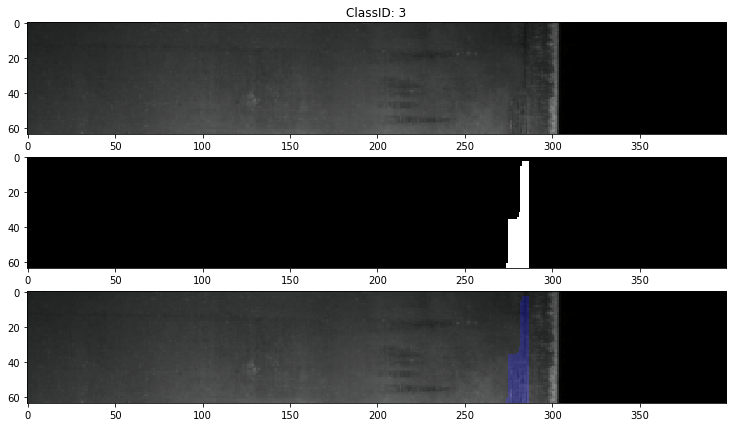

In [6]:
n = 1

fig, ax = plt.subplots(3, 1, figsize=(20, 7))
img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
mask = M_val[n].reshape(*params['size'])
ax[0].set_title('ClassID: {}'.format(y_val[n]))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')
img[mask == 1] = img[mask == 1] + params['colors'][y_val[n]]
ax[2].imshow(img)
plt.show()

### 4. Model

    a) Load SqueezeNet architecture
    b) Modify the classifier architecture
    c) Load the parameters
    d) Move model in GPU

In [7]:
### 4.1 Load architecture (### SPE)
net = models.squeezenet1_1(pretrained=True)
if 'Reduced' in MODEL_PATH:
    net.features = net.features[:10]
    net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, N_CLASSES))#, nn.Softmax(dim=1))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

### 5. Evaluation

    a) Compute the predicted labels and probabilities
    b) Compute metrics
    d) Plot ROC and Confusion Matrix

In [9]:
y_pred = []
y_true = []
y_score = torch.Tensor([])
batch_size = 2

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()

100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:20<00:00, 58.50it/s]


In [10]:
# tpr, fpr, threshold = roc_curve(y_true, y_score)
# auc_score = auc(fpr, tpr)
print('METRICS')
print('-----------------------------')
print('Accuracy:\t\t{:.4f}'.format(accuracy_score(y_true, y_pred)))
print('Balanced Accuracy:\t{:.4f}'.format(balanced_accuracy_score(y_true, y_pred)))
print('F1 Score (macro):\t{:.4f}'.format(f1_score(y_true, y_pred, average='macro')))
print('F1 Score (weighted):\t{:.4f}'.format(f1_score(y_true, y_pred, average='weighted')))

METRICS
-----------------------------
Accuracy:		0.9213
Balanced Accuracy:	0.9041
F1 Score (macro):	0.8511
F1 Score (weighted):	0.9237


In [11]:
fpr = dict()
tpr = dict()
roc_auc = dict()
macro_f1 = dict()
recall = dict()
precision = dict()
for i in range(N_CLASSES):
    y_tmp, y_pred_tmp = y_true.copy(), y_pred.copy()
    y_tmp[y_tmp != i] = N_CLASSES
    y_tmp[y_tmp == i] = N_CLASSES + 1
    y_tmp -= N_CLASSES
    y_pred_tmp[y_pred_tmp != i] = N_CLASSES
    y_pred_tmp[y_pred_tmp == i] = N_CLASSES + 1
    y_pred_tmp -= N_CLASSES
    
    fpr[i], tpr[i], _ = roc_curve(y_tmp, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    recall[i] = recall_score(y_tmp, y_pred_tmp)
    precision[i] = precision_score(y_tmp, y_pred_tmp)
    macro_f1[i] = f1_score(y_tmp, y_pred_tmp, labels='macro')
    

df = pd.DataFrame([recall.values(), precision.values(), macro_f1.values()], 
                  index = ['Recall', 'Precision', 'F1'],
                  columns = ['No Defect', 'Type 1', 'Type 2', 'Type 3', 'Type 4'])
df.transpose().round(3).head()

,Recall,Precision,F1
No Defect,0.939,0.944,0.941
Type 1,0.888,0.807,0.845
Type 2,0.864,0.494,0.628
Type 3,0.909,0.953,0.931
Type 4,0.922,0.898,0.910


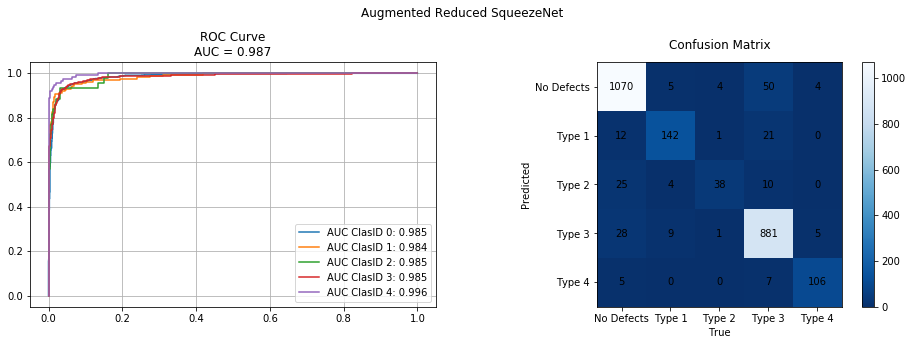

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))

fig.suptitle('Augmented Reduced SqueezeNet', y=1.05)
for i in range(N_CLASSES):
    ax[0].plot(fpr[i], tpr[i], label='AUC ClasID {}: {:.3f}'.format(i, roc_auc[i]))
ax[0].legend()
ax[0].grid()
ax[0].set_title('ROC Curve\nAUC = {:.3f}'.format(np.mean([i for i in roc_auc.values()])))

cm = confusion_matrix(y_pred, y_true)
cm_plot = ax[1].matshow(cm, cmap='Blues_r')
ax[1].set_title('Confusion Matrix', y=1.03)
ax[1].set_xlabel('True')
ax[1].set_ylabel('Predicted')
ax[1].xaxis.set_ticks_position('bottom')
plt.colorbar(cm_plot)
ax[1].set_xticklabels(['No Defects', 'No Defects', 'Type 1', 'Type 2', 'Type 3', 'Type 4'])
ax[1].set_yticklabels(['No Defects', 'No Defects', 'Type 1', 'Type 2', 'Type 3', 'Type 4'])
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        k = 0
        ax[1].text(j, i, cm[i, j], va='center', ha='center')

### I don't know CNN

In some situation is desirable that the CNN do not take a decision. In particular in cases where the probability of the chosen decision is not close to 1 but to 0.20.

In [13]:
errors = y_true[(y_pred-y_true) != 0].shape[0]
print('Number of errors: {}'.format(errors))
print('Number of right classification: {}'.format(X_val.shape[0]-errors))

Number of errors: 191
Number of right classification: 2237


In [71]:
probs = np.max(y_score, axis=1)
y_pred_new = y_pred.copy()
y_pred_new[probs < 0.85] = -1
y_strong_pred = y_pred_new.copy()
y_strong_pred = y_strong_pred[y_strong_pred > -1]
y_true_new = y_true[y_pred_new > -1]


print('METRICS')
print('-----------------------------')
print('Accuracy:\t\t{:.4f}'.format(accuracy_score(y_true_new, y_strong_pred)))
print('Balanced Accuracy:\t{:.4f}'.format(balanced_accuracy_score(y_true_new, y_strong_pred)))
print('F1 Score (macro):\t{:.4f}'.format(f1_score(y_true_new, y_strong_pred, average='macro')))
print('F1 Score (weighted):\t{:.4f}'.format(f1_score(y_true_new, y_strong_pred, average='weighted')))
print('-----------------------------')
errors_new = y_true_new[(y_strong_pred-y_true_new) != 0].shape[0]
not_classified = y_pred_new[y_pred_new == -1].shape[0]
print('Number of errors: {}'.format(errors_new))
print('Number of not classified example: {} ({:.1f}%). {} of these would have been errors'.format(not_classified, 
                                                                                              100*not_classified/X_val.shape[0],
                                                                                              errors-errors_new))
print('Number of classification: {}'.format(y_true_new.shape[0]))

METRICS
-----------------------------
Accuracy:		0.9731
Balanced Accuracy:	0.9557
F1 Score (macro):	0.9425
F1 Score (weighted):	0.9733
-----------------------------
Number of errors: 54
Number of not classified example: 417 (17.2%). 137 of these would have been errors
Number of classification: 2011


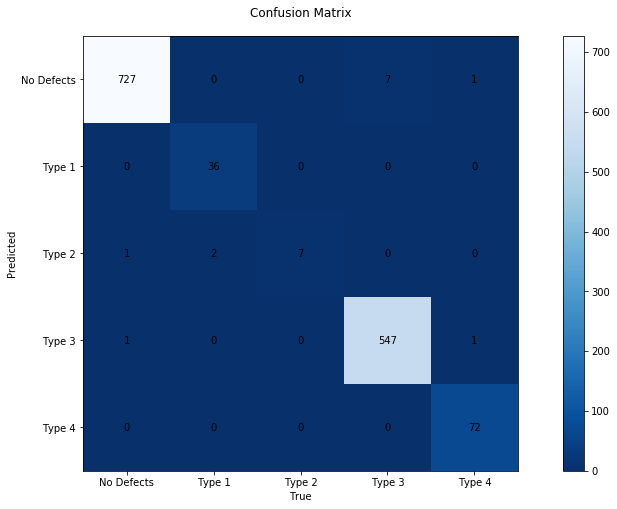

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
cm = confusion_matrix(y_strong_pred, y_true_new)
cm_plot = ax.matshow(cm, cmap='Blues_r')
ax.set_title('Confusion Matrix', y=1.03)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(cm_plot)
ax.set_xticklabels(['No Defects', 'No Defects', 'Type 1', 'Type 2', 'Type 3', 'Type 4'])
ax.set_yticklabels(['No Defects', 'No Defects', 'Type 1', 'Type 2', 'Type 3', 'Type 4'])
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        k = 0
        #ax.text(j, i, '{}\n({:.2f}%)'.format(cm[i, j], 100*cm[i, j]/cm.sum(axis=0)[j]), va='center', ha='center')
        ax.text(j, i, '{}'.format(cm[i, j]), va='center', ha='center')

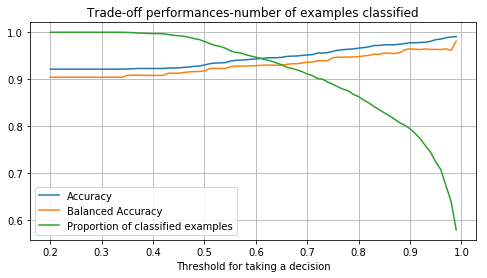

In [77]:
accuracy = []
balanced_accuracy = []
f1 = []
rfr_not_decided_ex = []
thresholds = np.arange(0.20, 1.00, 0.01)
for i in thresholds:
    y_pred_new = y_pred.copy()
    y_pred_new[probs < i] = -1
    y_strong_pred = y_pred_new.copy()
    y_strong_pred = y_strong_pred[y_strong_pred > -1]
    y_true_new = y_true[y_pred_new > -1]
    
    f1.append(f1_score(y_true_new, y_strong_pred, average='weighted'))
    accuracy.append(accuracy_score(y_true_new, y_strong_pred))
    balanced_accuracy.append(balanced_accuracy_score(y_true_new, y_strong_pred))
    rfr_not_decided_ex.append((X_val.shape[0] -y_pred_new[y_pred_new == -1].shape[0])/X_val.shape[0])

plt.figure(figsize=(8, 4))
plt.title('Trade-off performances-number of examples classified')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.plot(thresholds, balanced_accuracy, label='Balanced Accuracy')
#plt.plot(thresholds, f1, label='Weighted F1 score')
plt.plot(thresholds, rfr_not_decided_ex, label = 'Proportion of classified examples')
plt.xlabel('Threshold for taking a decision')
plt.legend()
plt.grid()
plt.show()